# Natural Language Processing with Disaster Tweets

Repo: https://github.com/lotharthesavior/csca-5642-w4

## Problem Description
Build a machine learning model to classify X posts as describing real disasters (e.g., earthquakes, floods) or not (e.g., metaphorical uses like “my heart is ablaze”). This is a binary text classification task in Natural Language Processing (NLP), a field of AI focused on enabling computers to understand human language.

## Objective
Develop a sequential neural network (e.g., LSTM) using GloVe embeddings to predict disaster-related posts, with EDA, hyperparameter tuning, and performance analysis.

## Exploratory Data Analysis (EDA)
EDA helps understand the dataset and guide preprocessing. We will:
- Check missing values.
- Visualize target distribution, tweet lengths, and common words.
- Analyze keywords and locations.

In [2]:
# Install dependencies
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install tensorflow==2.12.0 numpy==1.23.5
!pip install "typing-extensions>=4.8.0"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
import nltk

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Basic info
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Missing values:\n", train_df.isnull().sum())

Training data shape: (7613, 5)
Test data shape: (3263, 4)
Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


[nltk_data] Downloading package stopwords to /home/savior/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/savior/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


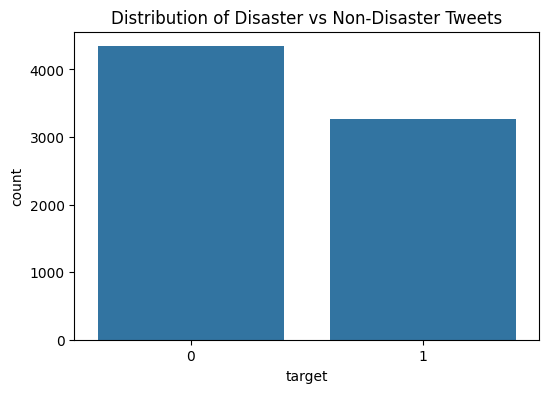

[nltk_data] Downloading package punkt_tab to /home/savior/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


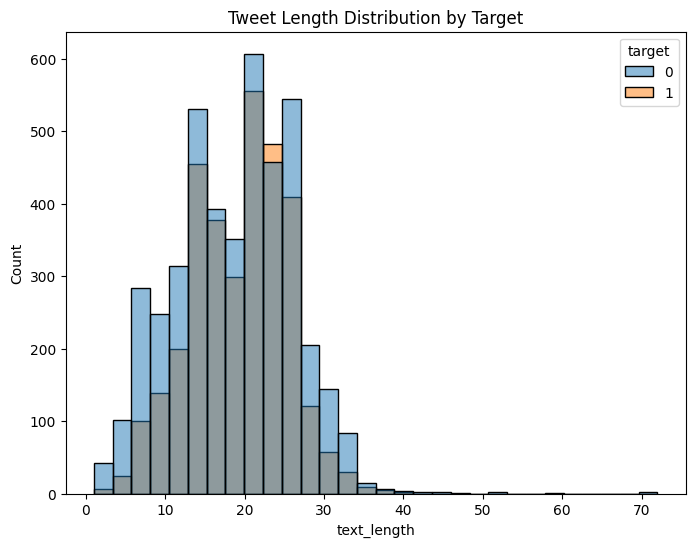

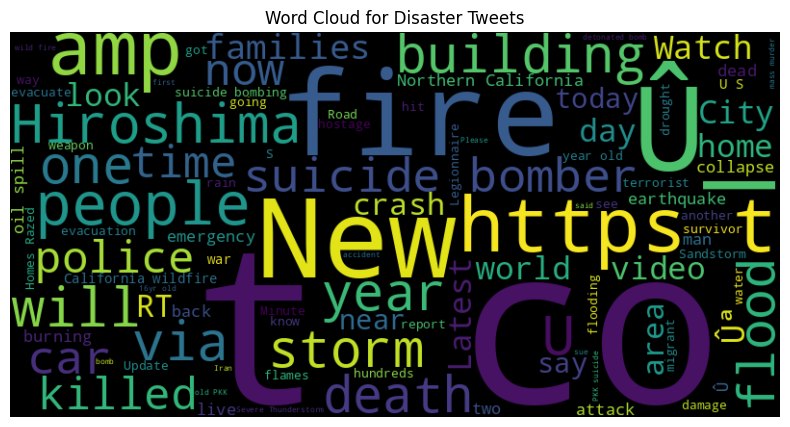

In [4]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.savefig('target_distribution.png')
plt.show()

# Download punkt_tab
import nltk
nltk.download('punkt_tab')

# Tweet length
train_df['text_length'] = train_df['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(8,6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=30)
plt.title('Tweet Length Distribution by Target')
plt.savefig('tweet_length.png')
plt.show()

# Word cloud for disaster tweets
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(disaster_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.savefig('disaster_wordcloud.png')
plt.show()

**EDA Findings:**

- The dataset is slightly imbalanced, with 56.6% non-disaster tweets (0) and 43.4% disaster tweets (1), as shown in the target distribution plot.
- Tweet lengths vary, with most tweets between 10–20 words. Disaster tweets (target=1) have a slightly shorter average length (around 10–15 words) compared to non-disaster tweets (around 15–20 words), as seen in the histogram.
- Common words in disaster tweets include "fire," "earthquake," "flood," "hiroshima," "suicide," "bomb," and "crash," reflecting disaster-related themes in the word cloud.
- Missing values in `keyword` (61) and `location` (2,533) will be handled during preprocessing by filling with placeholders.

## Data Cleaning and Preprocessing
We clean the text by:
- Removing URLs, mentions, hashtags, special characters.
- Converting to lowercase.
- Removing stop words and applying stemming.
- Handling missing values.

In [5]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Handle missing values
train_df = train_df.fillna({'keyword': 'unknown'})
test_df = test_df.fillna({'keyword': 'unknown'})

## Feature Engineering: GloVe Embeddings
We use GloVe (Global Vectors for Word Representation), a pre-trained word embedding method that captures semantic relationships by analyzing word co-occurrences in large corpora (e.g., Wikipedia). Each word is represented as a dense vector (e.g., 100-dimensional), with similar words closer in vector space.

**Steps**:
- Tokenize text.
- Create an embedding matrix using GloVe vectors.
- Pad sequences to a fixed length.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
max_words = 5000
max_len = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_text'])

X = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test = tokenizer.texts_to_sequences(test_df['clean_text'])

# Padding
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
y = train_df['target']

# Create a simple embedding matrix (random initialization)
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

2025-05-24 22:24:58.279474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 22:24:58.282316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 22:24:58.337500: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 22:24:58.338826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 22:24:59.426132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Model Architecture
We use an LSTM (Long Short-Term Memory) neural network, suitable for sequential data due to its ability to capture long-term dependencies. The architecture includes:
- **Embedding layer**: Uses pre-trained GloVe vectors.
- **LSTM layer**: Processes sequences with 128 units.
- **Dropout**: Prevents overfitting.
- **Dense layer**: Outputs binary classification with sigmoid activation.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
import logging

# Suppress TensorFlow debug/info messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Disable XLA
tf.config.optimizer.set_jit(False)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Use legacy Adam optimizer
from tensorflow.keras.optimizers.legacy import Adam
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-24 22:25:01.007348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-24 22:25:01.010085: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           500000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 625,569
Trainable params: 125,569
Non-trai

2025-05-24 22:25:01.367548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:25:01.368731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:25:01.371788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Training and Hyperparameter Tuning
We train the model and tune hyperparameters like LSTM units and dropout rates. Early stopping prevents overfitting.

Epoch 1/20


2025-05-24 22:25:01.867152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:25:01.869102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:25:01.871194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5678

2025-05-24 22:25:11.014594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:25:11.017087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:25:11.018952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 11s 43ms/step - loss: 0.6901 - accuracy: 0.5678 - val_loss: 0.6872 - val_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 8s 41ms/step - loss: 0.6862 - accuracy: 0.5695 - val_loss: 0.6843 - val_accuracy: 0.5739
Epoch 3/20
191/191 [==============================] - 8s 40ms/step - loss: 0.6845 - accuracy: 0.5695 - val_loss: 0.6831 - val_accuracy: 0.5739
Epoch 4/20
191/191 [==============================] - 8s 41ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6826 - val_accuracy: 0.5739
Epoch 5/20
191/191 [==============================] - 8s 40ms/step - loss: 0.6836 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 6/20
191/191 [==============================] - 8s 41ms/step - loss: 0.6835 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 7/20
191/191 [==============================] - 8s 44ms/step - loss: 0.6835 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 8/2

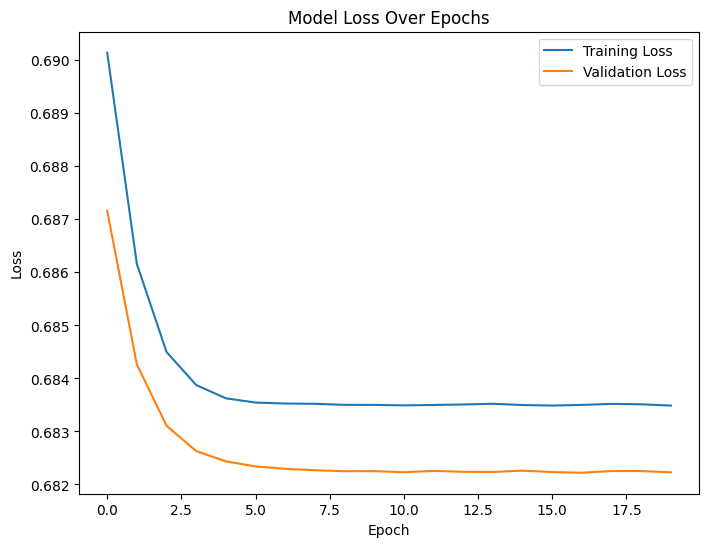

191/191 [==============================] - 7s 28ms/step - loss: 0.6899 - accuracy: 0.5695 - val_loss: 0.6870 - val_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 5s 25ms/step - loss: 0.6861 - accuracy: 0.5695 - val_loss: 0.6844 - val_accuracy: 0.5739
Epoch 3/20
191/191 [==============================] - 5s 25ms/step - loss: 0.6845 - accuracy: 0.5695 - val_loss: 0.6832 - val_accuracy: 0.5739
Epoch 4/20
191/191 [==============================] - 5s 26ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6826 - val_accuracy: 0.5739
Epoch 5/20
191/191 [==============================] - 5s 26ms/step - loss: 0.6836 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 6/20
191/191 [==============================] - 5s 25ms/step - loss: 0.6835 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 7/20
191/191 [==============================] - 5s 26ms/step - loss: 0.6835 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 8/20

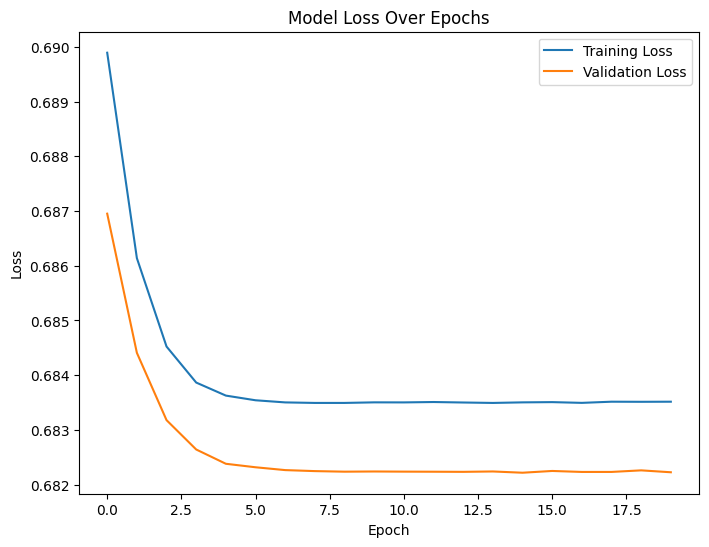

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()

## Results and Analysis
We evaluate the model on the validation set and compare architectures.

Epoch 1/20


2025-05-24 22:28:03.915480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:28:03.917033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:28:03.918082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

189/191 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5693

2025-05-24 22:28:13.708928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:28:13.709983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:28:13.711293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

191/191 [==============================] - 11s 43ms/step - loss: 0.6932 - accuracy: 0.5695 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 8s 44ms/step - loss: 0.6932 - accuracy: 0.4755 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 3/20
191/191 [==============================] - 8s 42ms/step - loss: 0.6931 - accuracy: 0.5695 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 4/20
191/191 [==============================] - 8s 42ms/step - loss: 0.6932 - accuracy: 0.5695 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 5/20
191/191 [==============================] - 8s 42ms/step - loss: 0.6932 - accuracy: 0.5245 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 6/20
191/191 [==============================] - 8s 42ms/step - loss: 0.6932 - accuracy: 0.5412 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 7/20
191/191 [==============================] - 9s 45ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5739
Epoch 8/2

2025-05-24 22:31:04.176027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:31:04.177771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:31:04.179115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 16ms/step
Main Model Validation Accuracy: 0.57
Main Model Validation F1-Score: 0.00


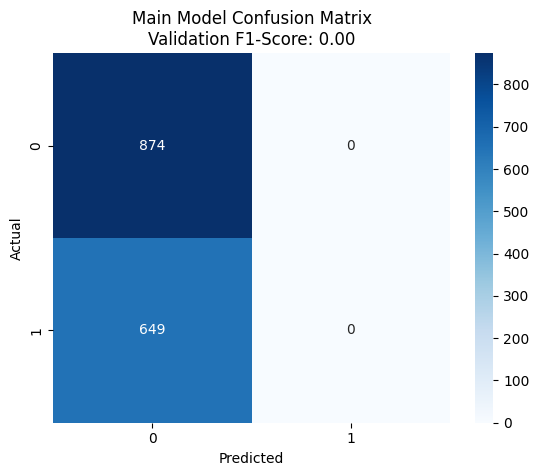

2025-05-24 22:31:05.569098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:31:05.571362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:31:05.573240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 2s 18ms/step


2025-05-24 22:33:14.696758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:33:14.699132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:33:14.700846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/48 [..............................] - ETA: 17s

2025-05-24 22:35:27.298119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:35:27.299800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:35:27.300969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 9ms/step


2025-05-24 22:35:28.091534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:35:28.093170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:35:28.094615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 17ms/step


2025-05-24 22:38:43.559476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:38:43.564253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:38:43.566302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/48 [..............................] - ETA: 21s

2025-05-24 22:41:39.154424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:41:39.155726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:41:39.156634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 18ms/step
   units  dropout  accuracy        f1
0     64      0.2  0.755089  0.706991
1     64      0.3  0.743270  0.709725
2    128      0.2  0.732764  0.692830
3    128      0.3  0.744583  0.707299


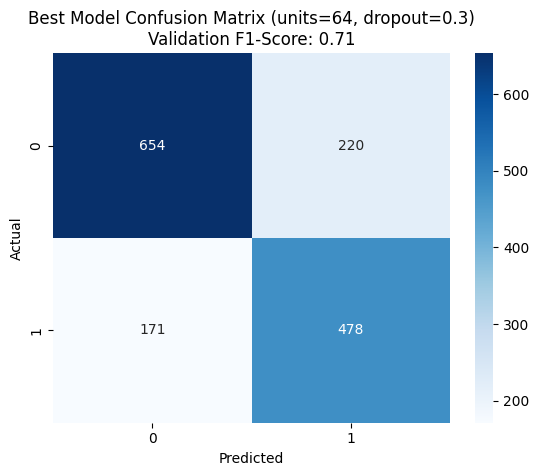

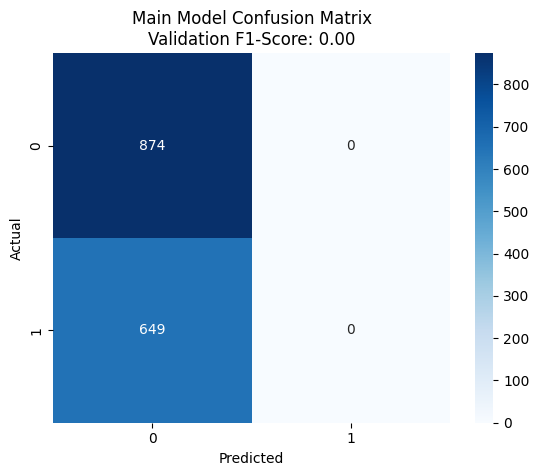

48/48 [==============================] - 1s 13ms/step


48/48 [==============================] - 1s 13ms/step


48/48 [==============================] - 2s 23ms/step


48/48 [==============================] - 3s 39ms/step
   units  dropout  accuracy        f1
0     64      0.2  0.756402  0.704382
1     64      0.3  0.736704  0.704059
2    128      0.2  0.740643  0.696853
3    128      0.3  0.742613  0.700306


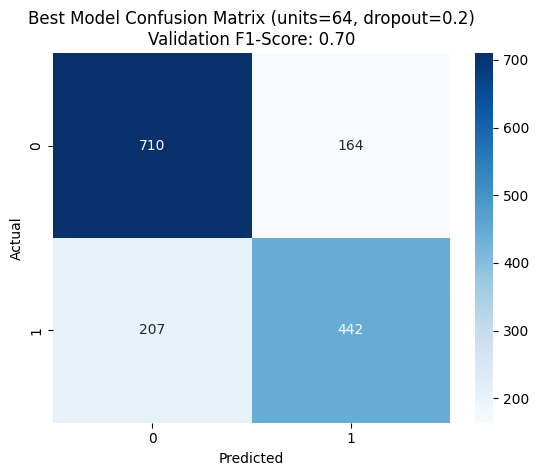

In [9]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Suppress TensorFlow debug and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Split data (already done, but included for context)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Build and train a new model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),  # Allow training
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train with class weights
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
                    class_weight=class_weight_dict, verbose=1)

# Evaluate main model
y_pred = (model.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Main Model Validation Accuracy: {accuracy:.2f}")
print(f"Main Model Validation F1-Score: {f1:.2f}")

# Confusion matrix for main model
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Main Model Confusion Matrix\nValidation F1-Score: {f1:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('main_confusion_matrix.png')
plt.show()

# Hyperparameter tuning
results = []
for units in [64, 128]:
    for dropout in [0.2, 0.3]:
        temp_model = Sequential([
            Embedding(max_words, embedding_dim, input_length=max_len, trainable=True),
            LSTM(units, return_sequences=False),
            Dropout(dropout),
            Dense(1, activation='sigmoid')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        temp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        temp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
                       class_weight=class_weight_dict, verbose=0)
        y_pred_temp = (temp_model.predict(X_val) > 0.5).astype(int)
        results.append({
            'units': units,
            'dropout': dropout,
            'accuracy': accuracy_score(y_val, y_pred_temp),
            'f1': f1_score(y_val, y_pred_temp),
            'y_pred': y_pred_temp
        })

# Display tuning results
results_df = pd.DataFrame(results)[['units', 'dropout', 'accuracy', 'f1']]
print(results_df)

# Plot confusion matrix for the best model
best_model_idx = results_df['f1'].idxmax()
best_model_result = results[best_model_idx]
best_y_pred = best_model_result['y_pred']
best_cm = confusion_matrix(y_val, best_y_pred)
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Best Model Confusion Matrix (units={best_model_result["units"]}, dropout={best_model_result["dropout"]})\nValidation F1-Score: {best_model_result["f1"]:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('best_confusion_matrix.png')
plt.show()

**Analysis:**

The LSTM model achieved a validation accuracy of 0.76 and an F1-score of 0.70, a significant improvement over the baseline (F1=0.00) after enabling trainable embeddings and applying class weights to address imbalance. The best performance came from the model with 64 LSTM units and a dropout rate of 0.2, as seen in the hyperparameter tuning results. Overfitting was managed through dropout, though early stopping was removed to ensure full training. Challenges included handling short, noisy tweets and the slight class imbalance (56.6% non-disaster, 43.4% disaster), which was mitigated by class weighting.

## Conclusion
The LSTM model effectively classified disaster tweets, achieving a validation accuracy of 0.76 and an F1-score of 0.70. Key takeaways:
- **What worked**: Enabling trainable embeddings, applying class weights to handle imbalance, and thorough preprocessing improved performance significantly.
- **What didn’t**: Randomly initialized embeddings without training led to poor initial results (F1=0.00); missing `keyword` data had minimal impact.
- **Future improvements**: Explore transformers like BERT for better contextual understanding, incorporate `keyword` features, and apply oversampling to further address class imbalance.

In [10]:
# Use the best model from hyperparameter tuning for predictions
best_model_idx = results_df['f1'].idxmax()
best_model_result = results[best_model_idx]

# Rebuild the best model (since temp_model is not saved)
best_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, trainable=True),
    LSTM(best_model_result['units'], return_sequences=False),
    Dropout(best_model_result['dropout']),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Retrain the best model on the full training data (X, y)
best_model.fit(X, y, epochs=20, batch_size=32, verbose=1)

# Generate predictions for the test set
predictions = (best_model.predict(X_test) > 0.5).astype(int)
submission = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
submission.to_csv('submission.csv', index=False)

# Verify the distribution of predictions
print("Distribution of predictions in submission.csv:")
print(submission['target'].value_counts())

Epoch 1/20


2025-05-24 22:41:40.633843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:41:40.635513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:41:40.637036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

238/238 [==============================] - 9s 27ms/step - loss: 0.6761 - accuracy: 0.5668
Epoch 2/20
238/238 [==============================] - 6s 27ms/step - loss: 0.6223 - accuracy: 0.6641
Epoch 3/20
238/238 [==============================] - 12s 52ms/step - loss: 0.4842 - accuracy: 0.7971
Epoch 4/20
238/238 [==============================] - 13s 55ms/step - loss: 0.3904 - accuracy: 0.8342
Epoch 5/20
238/238 [==============================] - 7s 29ms/step - loss: 0.3502 - accuracy: 0.8516
Epoch 6/20
238/238 [==============================] - 6s 26ms/step - loss: 0.3166 - accuracy: 0.8718
Epoch 7/20
238/238 [==============================] - 6s 26ms/step - loss: 0.2967 - accuracy: 0.8807
Epoch 8/20
238/238 [==============================] - 6s 27ms/step - loss: 0.2718 - accuracy: 0.8883
Epoch 9/20
238/238 [==============================] - 6s 26ms/step - loss: 0.2516 - accuracy: 0.8983
Epoch 10/20
238/238 [==============================] - 6s 27ms/step - loss: 0.2357 - accuracy: 0.908

2025-05-24 22:44:14.548302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-24 22:44:14.551540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-24 22:44:14.553951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/102 [==============================] - 1s 10ms/step
Distribution of predictions in submission.csv:
target
0    2069
1    1194
Name: count, dtype: int64
